## Segmentacion de Imagenes con CamVid
Traducción al español del la [clase de Fast.ai](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb) por [Fernando Bernuy B.](https://scholar.google.cl/citations?user=Q4tEQYYAAAAJ&hl)

Partiremos inicializando el notebook y las librerias

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import torch
#torch.cuda.set_device(2)
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

## Cargar Base de Datos
Para este caso utilizaremos una versión modificada de CamVid del paper `The One Hundred Layer Tiramisu`, con imágenes pequeñas y menos clases. Esta versión de CamVid esta disponible en el siguiente repositorio:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Al igual que en el caso anterior, vamos a usar links simbólicos de los datos de la base de datos para evitar problemas con la descarga, pero en condiciones normales, deberíamos hacer un `clone` del repositorio.

In [3]:
!mkdir ~/SegNet-Tutorial
!mkdir ~/SegNet-Tutorial/CamVid
!ln -s /data/home/instructor1/SegNet-Tutorial/CamVid/t* ~/SegNet-Tutorial/CamVid
!ln -s /data/home/instructor1/SegNet-Tutorial/CamVid/v* ~/SegNet-Tutorial/CamVid

mkdir: cannot create directory ‘/home/instructor1/SegNet-Tutorial’: File exists
mkdir: cannot create directory ‘/home/instructor1/SegNet-Tutorial/CamVid’: File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/test': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/testannot': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/test.txt': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/train': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/trainannot': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/train.txt': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/val': File exists
ln: failed to create symbolic link '/home/instructor1/SegNet-Tutorial/CamVid/valannot': File exists
ln: failed to create symbolic link '/home

In [4]:
#!cd ~
#!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Creamos el objeto Path apuntando a la base de la carpeta con la base de datos que descargamos y miramos el contenido.

In [5]:
path = Path.home()/'SegNet-Tutorial/CamVid'

In [6]:
path.ls()

[PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/val'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/test'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/models'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/train'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/testannot')]

## Data

¿Cómo están estructuradas las imágenes y sus etiquetas?

In [7]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/val/0016E5_08145.png'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/val/0016E5_08049.png'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/val/0016E5_08115.png')]

In [8]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/valannot/0016E5_08145.png'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/valannot/0016E5_08049.png'),
 PosixPath('/home/instructor1/SegNet-Tutorial/CamVid/valannot/0016E5_08115.png')]

Creamos un método que retorna el path a la imagen con las etiquetas a partir del path de la imagen original. Además, incluimos la equivalencia de etiqueta a `str` para nuestra interpretación.

In [9]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

Ahora veamos una imagen y su etiquetado:

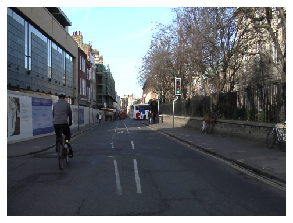

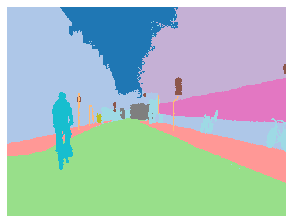

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Generamos los Datasets

Utilizaremos la mitad del tamaño de la imagen y debemos configurar el `batch_size` para que pueda funcionar en nuestro equipo.

In [12]:
bs,size = 6,src_size//2

In [13]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

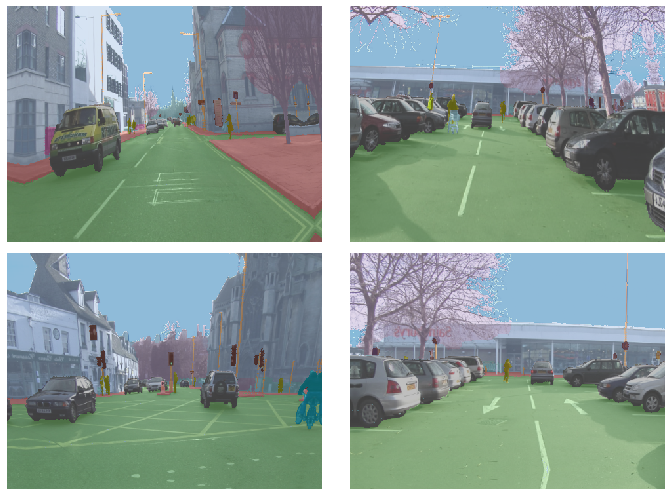

In [15]:
data.show_batch(2, figsize=(10,7))

## Cargamos el Modelo

La base de datos contiene una etiqueta `void` para referirse a todos los elementos que no estan incluidos dentro de las otras etiquetas, y no deben ser consideradas para la evaluacion del desempeño, por lo que debemos implementar una funcion de `accuracy` que considere este efecto como métrica.

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Para la segmentación utilizaremos la estructura [UNET](https://docs.fast.ai/vision.models.unet.html#DynamicUnet) a partir de un `resnet34`. Para esto utilizaremos la función [`unet_learner`](https://docs.fast.ai/vision.learner.html#unet_learner), que nos entregarar el `learner`apropiado para esta tarea.

In [17]:
metrics=acc_camvid
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).to_fp16()

elegimos un buen LR

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


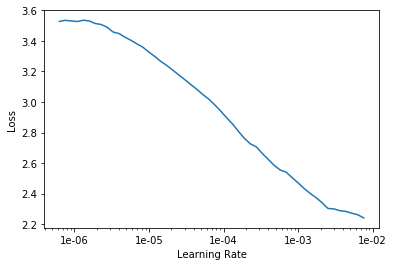

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=1e-4

y entrenamos un ciclo

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.308968,2.070673,0.539215,01:01
1,1.501184,1.205448,0.695645,00:56
2,1.036897,0.822070,0.799271,00:56
3,0.738542,0.591881,0.852871,00:56
4,0.596104,0.550199,0.856991,00:56
5,0.533026,0.438936,0.873035,00:56
6,0.464299,0.396656,0.880087,00:55
7,0.438501,0.368639,0.893580,00:56
8,0.399895,0.359255,0.891413,00:56
9,0.359849,0.326003,0.898777,00:56


In [22]:
learn.save('stage-1')

In [23]:
learn.load('stage-1');

Ahora hacemos fine-tunning de la red

In [24]:
learn.unfreeze()

In [25]:
lrs = slice(lr/100,lr)

In [26]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.329021,0.318597,0.902436,01:00
1,0.326125,0.326140,0.896967,00:59
2,0.320420,0.318748,0.900954,00:59
3,0.321189,0.319906,0.902610,00:59
4,0.319115,0.312043,0.908037,00:59
5,0.317338,0.298446,0.911443,00:59
6,0.315114,0.313052,0.912033,00:59
7,0.307384,0.360041,0.890982,00:59
8,0.309424,0.307595,0.911320,00:59
9,0.289523,0.323328,0.905730,00:59


In [27]:
learn.save('stage-2');

veamos como se comporto el entrenamiento

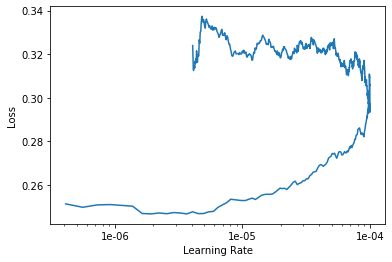

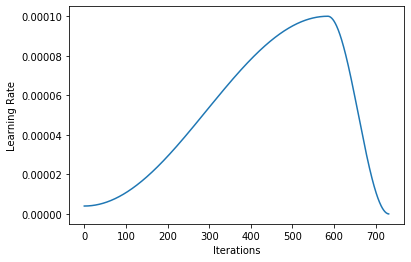

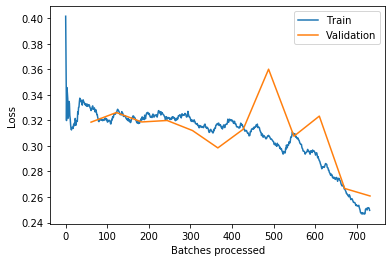

In [28]:
learn.recorder.plot()
learn.recorder.plot_lr()
learn.recorder.plot_losses()

## Ahora en grande

Vamos a utilizar las imágenes en tamaño completo. Para esto tenemos que corregir el tamaño en el `transform`, poner un `batch_size` apropiado y generar un nuevo `learn`.

Lo primero que haremos será borrar el `learn` anterior, para liberar la memoria de la GPU, y luego crearemos el nuevo.

In [29]:
learn=None
gc.collect()

10733

In [30]:
size = src_size
bs=4

In [31]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [32]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2').to_fp16();

buscamos un LR apropiado

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


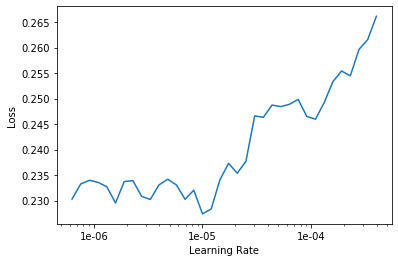

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=1e-4

entrenamos un ciclo

In [35]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.238919,0.264584,0.920391,01:00
1,0.234807,0.264474,0.921543,04:11
2,0.239540,0.272273,0.922074,00:55
3,0.240647,0.275511,0.924664,00:55
4,0.251446,0.272928,0.917913,00:56
5,0.249181,0.273253,0.922578,00:56
6,0.251718,0.256835,0.924798,00:55
7,0.250745,0.253787,0.923548,00:55
8,0.249255,0.248916,0.922557,00:55
9,0.215385,0.244419,0.927977,04:08


In [36]:
learn.save('stage-1-big')

observamos el comportamiento del entrenamiento

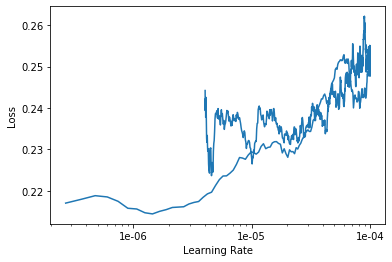

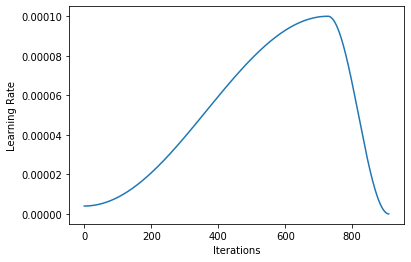

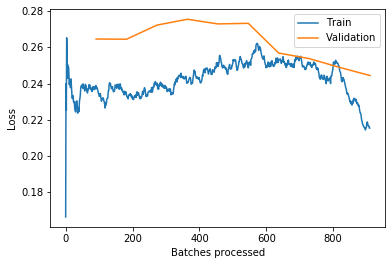

In [37]:
learn.recorder.plot()
learn.recorder.plot_lr()
learn.recorder.plot_losses()

In [38]:
learn.load('stage-1-big');

Hacemos una última etapa de fine-tunning

In [39]:
learn.unfreeze()

In [40]:
lrs = slice(lr/1000,lr/10)

In [41]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.203504,0.241023,0.927687,04:14
1,0.204665,0.246266,0.927155,01:00
2,0.202001,0.232828,0.931654,01:01
3,0.200976,0.229942,0.932194,01:00
4,0.200083,0.233298,0.929165,01:00
5,0.197082,0.232530,0.930968,01:00
6,0.193667,0.233415,0.930217,01:00
7,0.194349,0.231110,0.930429,01:00
8,0.194715,0.233554,0.929763,01:01
9,0.194381,0.232300,0.930318,01:01


In [42]:
learn.save('stage-2-big')

¿Como son los resultados?

Nos compararemos con el paper de [DenseNet](https://arxiv.org/pdf/1611.09326.pdf) (0.915)

In [43]:
learn.load('stage-2-big');

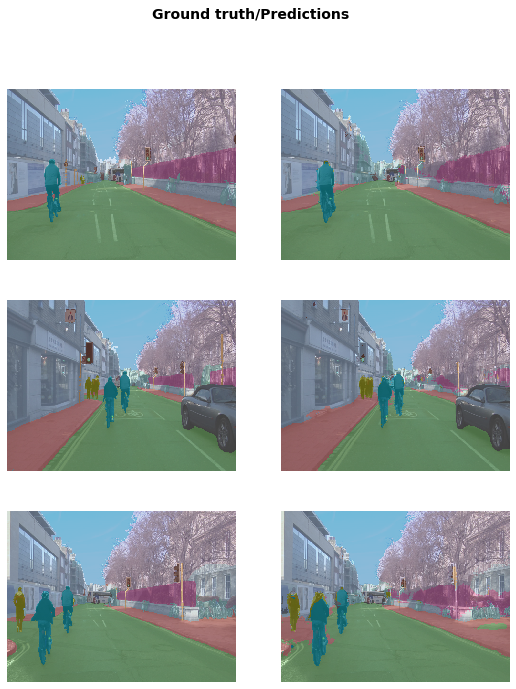

In [44]:
learn.show_results(rows=3, figsize=(9,11))

## FIN

In [45]:
# start: 480x360

In [46]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________